<a href="https://colab.research.google.com/github/Tyriek-cloud/Cox-Hazard-Model-Simulation/blob/main/Simulated_Data_CatBoost_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CatBoost Model on Synthetic Data**

In [ ]:
# Installing the necessary models
!pip install catboost lifelines pandas numpy scikit-learn gradio matplotlib

Alright. Let's start by doing the folloiwng:

*   Import all of the installed libraries.
*   Generate the synthetic/fake data.
*   Put all the data into an easy to work with dataframe.
*   Take a look at the data.

In [2]:
# Let's try Catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from catboost import CatBoostRegressor, Pool

# Set a random seed for reproducibility
np.random.seed(42)

# Generate Independent variables (IVs)
n = 2000 # number of samples
age = np.random.randint(22, 65, n)
sex = np.random.choice(['Male', 'Female'], n)
income = np.random.normal(50000, 15000, n)
usage_frequency = np.random.randint(1, 8, n)
engagement = np.random.normal(5, 2, n)
satisfaction = np.random.normal(7, 1.5, n)

# Dependent variables (DV)
time_to_event = np.random.exponential(5, n)
censor = np.random.binomial(1, 0.8, n)

# Confounding variables
time_of_year = np.random.choice(['Winter', 'Spring', 'Summer', 'Fall'], n)
service_changes = np.random.choice([0, 1], n)

# Create DataFrame
df = pd.DataFrame({
    'age': age,
    'sex': sex,
    'income': income,
    'usage_frequency': usage_frequency,
    'engagement': engagement,
    'satisfaction': satisfaction,
    'time_to_event': time_to_event,
    'censor': censor,
    'time_of_year': time_of_year,
    'service_changes': service_changes
})

# Call the head (first 5 rows) for observation
print(df.head())

   age     sex        income  usage_frequency  engagement  satisfaction  \
0   60  Female  58903.350834                5    2.176297      6.708669   
1   50  Female   5894.170480                2    4.522475      5.504714   
2   36  Female  59838.511648                2    8.862222      5.802839   
3   64  Female  52921.042921                5    6.717954      6.251257   
4   29    Male  49719.368653                6    4.242050      5.581261   

   time_to_event  censor time_of_year  service_changes  
0       5.060297       1       Summer                0  
1      10.666087       0         Fall                1  
2       3.805956       1       Spring                0  
3       7.117000       1       Summer                1  
4       7.199754       0       Spring                1  


That looks alright. However, it is not necessarily the most "real-world" looking. Let's observe some of the interactions between the variables and add some "noise" to the data.

In [3]:
# Label encoder for the sex and time of year variables
label_encoder = LabelEncoder()
df['sex'] = label_encoder.fit_transform(df['sex'])
df['time_of_year'] = label_encoder.fit_transform(df['time_of_year'])

# One-hot encode the service_changes (outages) variable
df = pd.get_dummies(df, columns=['service_changes'], drop_first=True)

# Interaction terms and nonlinear transformations
df['age_income'] = df['age'] * df['income']
df['engagement_satisfaction'] = df['engagement'] * df['satisfaction']
df['usage_service_change'] = df['usage_frequency'] * df['service_changes_1']
df['age_squared'] = df['age'] ** 2
df['income_squared'] = df['income'] ** 2

# Create age bins
df['age_bins'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 70], labels=False)
df['income'] = np.clip(df['income'], df['income'].quantile(0.05), df['income'].quantile(0.95))
df['income_log'] = np.log1p(df['income'])

# Scale continuous variables
scaler = StandardScaler()
scaled_features = ['age', 'income', 'usage_frequency', 'engagement', 'satisfaction', 'age_income',
                   'engagement_satisfaction', 'usage_service_change', 'age_squared', 'income_squared', 'income_log']
df[scaled_features] = scaler.fit_transform(df[scaled_features])

# Calling head to ensure that the data pre-processing is working
print(df.head())

        age  sex    income  usage_frequency  engagement  satisfaction  \
0  1.372783    0  0.653401         0.518315   -1.428284     -0.170196   
1  0.560028    0 -1.785924        -0.989145   -0.256056     -0.964047   
2 -0.577828    0  0.721745        -0.989145    1.912224     -0.767472   
3  1.697884    0  0.216197         0.518315    0.840878     -0.471799   
4 -1.146756    1 -0.017790         1.020802   -0.396165     -0.913574   

   time_to_event  censor  time_of_year  service_changes_1  age_income  \
0       5.060297       1             2              False    1.507644   
1      10.666087       0             0               True   -2.032951   
2       3.805956       1             1              False   -0.000640   
3       7.117000       1             2               True    1.346703   
4       7.199754       0             1               True   -0.779173   

   engagement_satisfaction  usage_service_change  age_squared  income_squared  \
0                -1.258092             -0

That looks fine. Now it's time to define and train the model. Ideally, we want to run the model on the best possible features/variables. Instead of doing the manual work of finding the best features, we will perform a search on the entire synthetic dataset.

In [5]:
# Time to fit a model
# Split data into training and validation sets
# Impute in case there is missing data (leaving at the mean is fine for now)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(df.drop(['time_to_event', 'censor'], axis=1))
y = df[['time_to_event', 'censor']] # Time to event and censor indicator
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for RandomizedSearchCV for CatBoost
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 5, 6, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bylevel': [0.7, 0.8, 1.0],
    'l2_leaf_reg': [0.1, 0.5, 1.0],
    'iterations': [100, 200, 300],
    'min_data_in_leaf': [1, 5, 10],
}

# Setup RandomizedSearchCV for CatBoost
random_search = RandomizedSearchCV(
    CatBoostRegressor(loss_function='Cox', cat_features=[], eval_metric='Cox', thread_count=-1),
    param_distributions=param_grid,
    n_iter=50,
    scoring=make_scorer(concordance_index),
    cv=3,
    verbose=1,
    random_state=42
)

# Perform Randomized Search
random_search.fit(X_train, y_train['time_to_event'])

# Print best parameters and score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Concordance Index: {random_search.best_score_}")

# Train the final model with best parameters
best_params = random_search.best_params_
catboost_model = CatBoostRegressor(loss_function='Cox', eval_metric='Cox', cat_features=[], thread_count=-1, **best_params)
catboost_model.fit(X_train, y_train['time_to_event'])

# Predict on the validation set
predictions = catboost_model.predict(X_val)

# Calculate Concordance Index (C-index) for validation data
c_index = concordance_index(y_val['time_to_event'], predictions, y_val['censor'])
print(f'Concordance Index (C-index) for CatBoost model: {c_index}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
0:	learn: -6367.6019378	total: 51.9ms	remaining: 15.5s
1:	learn: -6366.2947040	total: 55.8ms	remaining: 8.31s
2:	learn: -6364.4121872	total: 59.6ms	remaining: 5.9s
3:	learn: -6362.2180330	total: 63.3ms	remaining: 4.68s
4:	learn: -6360.9228838	total: 66.9ms	remaining: 3.95s
5:	learn: -6359.4932979	total: 70.7ms	remaining: 3.47s
6:	learn: -6357.8881726	total: 74.5ms	remaining: 3.12s
7:	learn: -6356.4135807	total: 78.2ms	remaining: 2.85s
8:	learn: -6355.4934741	total: 81.9ms	remaining: 2.65s
9:	learn: -6354.0457339	total: 85.7ms	remaining: 2.48s
10:	learn: -6353.0552128	total: 89.7ms	remaining: 2.36s
11:	learn: -6351.0863418	total: 93.5ms	remaining: 2.24s
12:	learn: -6349.7531508	total: 97.4ms	remaining: 2.15s
13:	learn: -6349.1498047	total: 101ms	remaining: 2.07s
14:	learn: -6348.1150336	total: 105ms	remaining: 2s
15:	learn: -6347.1520936	total: 109ms	remaining: 1.93s
16:	learn: -6346.4282803	total: 112ms	remaining: 1.87s
17:	

Training has stopped (degenerate solution on iteration 53, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 47, probably too small l2-regularization, try to increase it)


0:	learn: -6376.3061639	total: 1.6ms	remaining: 159ms
1:	learn: -6375.8157208	total: 3.02ms	remaining: 148ms
2:	learn: -6372.3349728	total: 4.34ms	remaining: 140ms
3:	learn: -6373.1810231	total: 5.74ms	remaining: 138ms
4:	learn: -6373.0686514	total: 7.24ms	remaining: 137ms
5:	learn: -6370.0022043	total: 8.72ms	remaining: 137ms
6:	learn: -6376.9844458	total: 10ms	remaining: 133ms
7:	learn: -6375.8455022	total: 11.4ms	remaining: 131ms
8:	learn: -6375.3425130	total: 12.8ms	remaining: 129ms
9:	learn: -6376.0006403	total: 14.2ms	remaining: 128ms
10:	learn: -6402.9162262	total: 15.7ms	remaining: 127ms
11:	learn: -6406.8152934	total: 17.1ms	remaining: 125ms
12:	learn: -6462.7751214	total: 18.3ms	remaining: 123ms
13:	learn: -6577.7937604	total: 19.6ms	remaining: 120ms
14:	learn: -6749.4481816	total: 20.9ms	remaining: 119ms
15:	learn: -6859.9907821	total: 22.3ms	remaining: 117ms
16:	learn: -7209.2691124	total: 23.8ms	remaining: 116ms
17:	learn: -7273.3226553	total: 25.2ms	remaining: 115ms
18:	l

Training has stopped (degenerate solution on iteration 189, probably too small l2-regularization, try to increase it)


14:	learn: -8762.6074413	total: 62ms	remaining: 1.18s
15:	learn: -9079.8898986	total: 71.6ms	remaining: 1.27s
16:	learn: -9278.3681498	total: 78.1ms	remaining: 1.3s
17:	learn: -9343.8425688	total: 82ms	remaining: 1.28s
18:	learn: -9381.8643688	total: 84.5ms	remaining: 1.25s
19:	learn: -9342.7737726	total: 87ms	remaining: 1.22s
20:	learn: -9338.1346501	total: 90.8ms	remaining: 1.21s
21:	learn: -9211.6353324	total: 94.5ms	remaining: 1.19s
22:	learn: -9095.7263429	total: 98.2ms	remaining: 1.18s
23:	learn: -8967.5121566	total: 102ms	remaining: 1.17s
24:	learn: -8258.8450538	total: 106ms	remaining: 1.16s
25:	learn: -8592.5301838	total: 110ms	remaining: 1.16s
26:	learn: -8792.4045208	total: 113ms	remaining: 1.15s
27:	learn: -8875.6578933	total: 117ms	remaining: 1.14s
28:	learn: -8927.4795990	total: 121ms	remaining: 1.13s
29:	learn: -8860.0714358	total: 125ms	remaining: 1.13s
30:	learn: -8896.0663413	total: 129ms	remaining: 1.12s
31:	learn: -8861.7422254	total: 133ms	remaining: 1.11s
32:	lear

Training has stopped (degenerate solution on iteration 66, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 53, probably too small l2-regularization, try to increase it)


46:	learn: -14585.6591774	total: 70ms	remaining: 78.9ms
47:	learn: -42263.2954950	total: 75.2ms	remaining: 81.5ms
48:	learn: -271478.8407503	total: 79.1ms	remaining: 82.3ms
49:	learn: -270833.2488779	total: 80.9ms	remaining: 80.9ms
50:	learn: -267886.1746937	total: 82.5ms	remaining: 79.3ms
51:	learn: -273581.6935097	total: 83.9ms	remaining: 77.4ms
52:	learn: -52765.0808755	total: 85.5ms	remaining: 75.8ms
0:	learn: -6374.3553591	total: 1.65ms	remaining: 163ms
1:	learn: -6372.5986532	total: 3.24ms	remaining: 159ms
2:	learn: -6372.0612621	total: 4.74ms	remaining: 153ms
3:	learn: -6368.7510357	total: 6.34ms	remaining: 152ms
4:	learn: -6368.3605694	total: 7.75ms	remaining: 147ms
5:	learn: -6366.9274415	total: 9.31ms	remaining: 146ms
6:	learn: -6389.6760670	total: 10.7ms	remaining: 143ms
7:	learn: -6499.2682433	total: 12.3ms	remaining: 141ms
8:	learn: -6915.9169294	total: 13.6ms	remaining: 137ms
9:	learn: -7830.6456962	total: 15ms	remaining: 135ms
10:	learn: -8903.8862016	total: 16.4ms	remai

Training has stopped (degenerate solution on iteration 50, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 44, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 24, probably too small l2-regularization, try to increase it)


20:	learn: -6377.9695123	total: 32ms	remaining: 426ms
21:	learn: -6421.7454146	total: 34.6ms	remaining: 438ms
22:	learn: -6482.4325726	total: 36.7ms	remaining: 442ms
23:	learn: -6582.4028478	total: 38.6ms	remaining: 444ms
24:	learn: -6757.2428803	total: 40ms	remaining: 440ms
25:	learn: -6966.5298277	total: 41.5ms	remaining: 438ms
26:	learn: -7289.5217820	total: 42.8ms	remaining: 433ms
27:	learn: -7683.5523768	total: 44.1ms	remaining: 429ms
28:	learn: -8202.9387541	total: 45.4ms	remaining: 425ms
29:	learn: -8763.7475194	total: 46.8ms	remaining: 421ms
30:	learn: -9254.9423344	total: 48.1ms	remaining: 417ms
31:	learn: -9624.4971248	total: 49.3ms	remaining: 413ms
32:	learn: -10190.0807707	total: 50.9ms	remaining: 412ms
33:	learn: -10060.4761121	total: 52.5ms	remaining: 410ms
34:	learn: -10172.5973958	total: 54ms	remaining: 409ms
35:	learn: -10917.4505894	total: 55.3ms	remaining: 406ms
36:	learn: -11578.8920454	total: 56.7ms	remaining: 403ms
37:	learn: -15390.7915583	total: 58ms	remaining: 

Training has stopped (degenerate solution on iteration 43, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 23, probably too small l2-regularization, try to increase it)


0:	learn: -6371.6592478	total: 5.09ms	remaining: 1.01s
1:	learn: -6366.8090446	total: 10ms	remaining: 991ms
2:	learn: -6360.3745377	total: 21.2ms	remaining: 1.39s
3:	learn: -6372.5090440	total: 24.3ms	remaining: 1.19s
4:	learn: -6459.3358107	total: 26.9ms	remaining: 1.05s
5:	learn: -6811.2698083	total: 30ms	remaining: 970ms
6:	learn: -7652.5404314	total: 32.9ms	remaining: 906ms
7:	learn: -8692.4135314	total: 35.2ms	remaining: 846ms
8:	learn: -11028.1522162	total: 38ms	remaining: 807ms
9:	learn: -12051.4710807	total: 38.8ms	remaining: 737ms
10:	learn: -13777.1913782	total: 41.3ms	remaining: 710ms
11:	learn: -30213.7363888	total: 44.3ms	remaining: 693ms
12:	learn: -35626.8584833	total: 47.1ms	remaining: 678ms
13:	learn: -47527.8104937	total: 50ms	remaining: 664ms
14:	learn: -175232.1362335	total: 52.5ms	remaining: 647ms
15:	learn: -199546.1463246	total: 55.6ms	remaining: 639ms
16:	learn: 166490.3232478	total: 59.1ms	remaining: 636ms
17:	learn: nan	total: 65.2ms	remaining: 659ms
18:	learn

Training has stopped (degenerate solution on iteration 20, probably too small l2-regularization, try to increase it)


29:	learn: -6361.5644260	total: 106ms	remaining: 247ms
30:	learn: -6361.2103157	total: 115ms	remaining: 257ms
31:	learn: -6361.0786937	total: 120ms	remaining: 255ms
32:	learn: -6360.7570140	total: 123ms	remaining: 250ms
33:	learn: -6360.5822732	total: 126ms	remaining: 245ms
34:	learn: -6360.2694288	total: 129ms	remaining: 240ms
35:	learn: -6359.7661607	total: 132ms	remaining: 235ms
36:	learn: -6359.5236291	total: 136ms	remaining: 231ms
37:	learn: -6359.2294044	total: 138ms	remaining: 226ms
38:	learn: -6358.9521872	total: 142ms	remaining: 223ms
39:	learn: -6358.5459177	total: 146ms	remaining: 219ms
40:	learn: -6358.3490473	total: 149ms	remaining: 215ms
41:	learn: -6358.0781459	total: 152ms	remaining: 210ms
42:	learn: -6357.9151451	total: 155ms	remaining: 206ms
43:	learn: -6357.6032386	total: 158ms	remaining: 202ms
44:	learn: -6357.2892976	total: 161ms	remaining: 197ms
45:	learn: -6356.9066038	total: 165ms	remaining: 193ms
46:	learn: -6356.7038753	total: 169ms	remaining: 190ms
47:	learn:

Training has stopped (degenerate solution on iteration 43, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 23, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 20, probably too small l2-regularization, try to increase it)


0:	learn: -6373.9211230	total: 4.45ms	remaining: 441ms
1:	learn: -6368.2769609	total: 7.64ms	remaining: 374ms
2:	learn: -6366.8993836	total: 11ms	remaining: 354ms
3:	learn: -6377.2943546	total: 14ms	remaining: 337ms
4:	learn: -6507.3393329	total: 16.7ms	remaining: 318ms
5:	learn: -7215.7483559	total: 19.8ms	remaining: 310ms
6:	learn: -7824.8581904	total: 22.6ms	remaining: 300ms
7:	learn: -8445.0666883	total: 24.9ms	remaining: 286ms
8:	learn: -8988.0912874	total: 27.7ms	remaining: 280ms
9:	learn: -9771.6403265	total: 30.4ms	remaining: 274ms
10:	learn: -12268.0009501	total: 33.3ms	remaining: 269ms
11:	learn: -13504.5001682	total: 35.9ms	remaining: 263ms
12:	learn: -19349.0990124	total: 38.7ms	remaining: 259ms
13:	learn: -28257.3426773	total: 42.1ms	remaining: 258ms
14:	learn: -132335.4480605	total: 44.9ms	remaining: 254ms
15:	learn: -266894.8657387	total: 47.8ms	remaining: 251ms
16:	learn: nan	total: 49.2ms	remaining: 240ms
17:	learn: nan	total: 52.6ms	remaining: 240ms
18:	learn: nan	tot

Training has stopped (degenerate solution on iteration 57, probably too small l2-regularization, try to increase it)


28:	learn: -6464.0248880	total: 43ms	remaining: 105ms
29:	learn: -6551.4738920	total: 44.2ms	remaining: 103ms
30:	learn: -6704.6361967	total: 45.4ms	remaining: 101ms
31:	learn: -6975.7962805	total: 47ms	remaining: 99.9ms
32:	learn: -7414.0499290	total: 51.1ms	remaining: 104ms
33:	learn: -8072.1839067	total: 52.7ms	remaining: 102ms
34:	learn: -8925.3335593	total: 56.6ms	remaining: 105ms
35:	learn: -9856.0849165	total: 58.1ms	remaining: 103ms
36:	learn: -11927.7888834	total: 60.7ms	remaining: 103ms
37:	learn: -11671.9162786	total: 65ms	remaining: 106ms
38:	learn: -7932.7023744	total: 67.6ms	remaining: 106ms
39:	learn: -7972.9513429	total: 73.4ms	remaining: 110ms
40:	learn: -8793.4766165	total: 76.8ms	remaining: 111ms
41:	learn: -9808.1130563	total: 80.2ms	remaining: 111ms
42:	learn: -10707.4331879	total: 82ms	remaining: 109ms
43:	learn: -10778.0585370	total: 87.1ms	remaining: 111ms
44:	learn: -10754.8540192	total: 89.3ms	remaining: 109ms
45:	learn: -10788.0075057	total: 90.8ms	remaining:

Training has stopped (degenerate solution on iteration 81, probably too small l2-regularization, try to increase it)


0:	learn: -6376.3154945	total: 3.22ms	remaining: 318ms
1:	learn: -6374.3562299	total: 7.09ms	remaining: 348ms
2:	learn: -6374.5425463	total: 8.77ms	remaining: 284ms
3:	learn: -6372.2835792	total: 10.9ms	remaining: 260ms
4:	learn: -6399.1473869	total: 16.4ms	remaining: 312ms
5:	learn: -6744.6964120	total: 18ms	remaining: 282ms
6:	learn: -7456.7400718	total: 22ms	remaining: 292ms
7:	learn: -8187.8334214	total: 23.6ms	remaining: 271ms
8:	learn: -8958.8230767	total: 27.5ms	remaining: 278ms
9:	learn: -10475.9186226	total: 30.6ms	remaining: 275ms
10:	learn: -8672.9608821	total: 33.3ms	remaining: 269ms
11:	learn: -9168.5043328	total: 36.8ms	remaining: 270ms
12:	learn: -9251.0549304	total: 39.3ms	remaining: 263ms
13:	learn: -10204.0160689	total: 40.8ms	remaining: 250ms
14:	learn: -10876.2464208	total: 42.5ms	remaining: 241ms
15:	learn: -10454.9290495	total: 48.1ms	remaining: 253ms
16:	learn: -10943.2663137	total: 50.5ms	remaining: 247ms
17:	learn: -10395.9776574	total: 51.9ms	remaining: 236ms


Training has stopped (degenerate solution on iteration 74, probably too small l2-regularization, try to increase it)


4:	learn: -6363.4921663	total: 13ms	remaining: 508ms
5:	learn: -6362.2267217	total: 16ms	remaining: 518ms
6:	learn: -6361.4242873	total: 19.8ms	remaining: 546ms
7:	learn: -6360.1122069	total: 25.5ms	remaining: 612ms
8:	learn: -6359.2284580	total: 27ms	remaining: 573ms
9:	learn: -6358.8157375	total: 29ms	remaining: 551ms
10:	learn: -6357.9516686	total: 30.7ms	remaining: 528ms
11:	learn: -6356.7172992	total: 32.5ms	remaining: 509ms
12:	learn: -6356.4037662	total: 34.5ms	remaining: 496ms
13:	learn: -6354.9372041	total: 36.3ms	remaining: 483ms
14:	learn: -6354.1339203	total: 38.2ms	remaining: 471ms
15:	learn: -6353.5364703	total: 40.1ms	remaining: 461ms
16:	learn: -6352.2341186	total: 42ms	remaining: 452ms
17:	learn: -6351.4033463	total: 44.1ms	remaining: 446ms
18:	learn: -6350.0506366	total: 46ms	remaining: 438ms
19:	learn: -6348.6377313	total: 47.9ms	remaining: 431ms
20:	learn: -6347.6109587	total: 49.7ms	remaining: 423ms
21:	learn: -6346.3393147	total: 51.7ms	remaining: 418ms
22:	learn:

Training has stopped (degenerate solution on iteration 73, probably too small l2-regularization, try to increase it)


Streaming output truncated to the last 5000 lines.
41:	learn: -6407.6077621	total: 101ms	remaining: 139ms
42:	learn: -6423.8662705	total: 105ms	remaining: 139ms
43:	learn: -6439.3197971	total: 108ms	remaining: 138ms
44:	learn: -6456.9534158	total: 110ms	remaining: 135ms
45:	learn: -6476.5639493	total: 113ms	remaining: 132ms
46:	learn: -6499.9443392	total: 115ms	remaining: 129ms
47:	learn: -6524.6677726	total: 117ms	remaining: 126ms
48:	learn: -6563.2388167	total: 119ms	remaining: 124ms
49:	learn: -6583.3716911	total: 121ms	remaining: 121ms
50:	learn: -6630.8490387	total: 123ms	remaining: 118ms
51:	learn: -6674.1332131	total: 125ms	remaining: 115ms
52:	learn: -6721.0791986	total: 126ms	remaining: 112ms
53:	learn: -6773.9695858	total: 128ms	remaining: 109ms
54:	learn: -6834.7717408	total: 130ms	remaining: 107ms
55:	learn: -6902.0871670	total: 133ms	remaining: 104ms
56:	learn: -6976.3338079	total: 135ms	remaining: 102ms
57:	learn: -7055.8717908	total: 137ms	remaining: 99.2ms
58:	learn: -7

Training has stopped (degenerate solution on iteration 225, probably too small l2-regularization, try to increase it)


16:	learn: -6342.2751351	total: 68.1ms	remaining: 1.13s
17:	learn: -6344.0153321	total: 72.6ms	remaining: 1.14s
18:	learn: -6351.2954331	total: 79ms	remaining: 1.17s
19:	learn: -6359.4118276	total: 84.7ms	remaining: 1.19s
20:	learn: -6372.7080380	total: 90ms	remaining: 1.2s
21:	learn: -6393.4812643	total: 93.9ms	remaining: 1.19s
22:	learn: -6423.8153367	total: 95.6ms	remaining: 1.15s
23:	learn: -6471.1239855	total: 97.9ms	remaining: 1.13s
24:	learn: -6540.7719277	total: 102ms	remaining: 1.12s
25:	learn: -6631.4357511	total: 105ms	remaining: 1.11s
26:	learn: -6765.9711423	total: 109ms	remaining: 1.1s
27:	learn: -6946.1637783	total: 113ms	remaining: 1.1s
28:	learn: -7166.6558324	total: 115ms	remaining: 1.07s
29:	learn: -7463.5718706	total: 116ms	remaining: 1.04s
30:	learn: -7812.4494971	total: 120ms	remaining: 1.04s
31:	learn: -8208.5963287	total: 124ms	remaining: 1.03s
32:	learn: -8651.3807674	total: 129ms	remaining: 1.04s
33:	learn: -9356.5152895	total: 133ms	remaining: 1.04s
34:	learn

Training has stopped (degenerate solution on iteration 142, probably too small l2-regularization, try to increase it)


9:	learn: -6467.2283099	total: 45.5ms	remaining: 1.32s
10:	learn: -6557.8385450	total: 53.3ms	remaining: 1.4s
11:	learn: -6713.4967077	total: 61.7ms	remaining: 1.48s
12:	learn: -6713.7094014	total: 65.8ms	remaining: 1.45s
13:	learn: -6964.5617759	total: 69.5ms	remaining: 1.42s
14:	learn: -7314.7654789	total: 73.3ms	remaining: 1.39s
15:	learn: -7747.4875631	total: 77ms	remaining: 1.37s
16:	learn: -8195.8497049	total: 81ms	remaining: 1.35s
17:	learn: -8595.0195990	total: 84.8ms	remaining: 1.33s
18:	learn: -8145.4164359	total: 87.4ms	remaining: 1.29s
19:	learn: -8562.8448581	total: 89.9ms	remaining: 1.26s
20:	learn: -8891.4657651	total: 93.6ms	remaining: 1.24s
21:	learn: -9067.2897982	total: 97.4ms	remaining: 1.23s
22:	learn: -9137.1714470	total: 101ms	remaining: 1.22s
23:	learn: -9066.2190806	total: 105ms	remaining: 1.21s
24:	learn: -9038.4279731	total: 107ms	remaining: 1.17s
25:	learn: -8997.0777589	total: 110ms	remaining: 1.16s
26:	learn: -8904.1742653	total: 114ms	remaining: 1.15s
27:

Training has stopped (degenerate solution on iteration 51, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 32, probably too small l2-regularization, try to increase it)


0:	learn: -6373.8869043	total: 6.28ms	remaining: 1.88s
1:	learn: -6370.1798882	total: 11.5ms	remaining: 1.72s
2:	learn: -6367.4273809	total: 19ms	remaining: 1.88s
3:	learn: -6364.0266609	total: 21.9ms	remaining: 1.62s
4:	learn: -6363.6980240	total: 23.6ms	remaining: 1.39s
5:	learn: -6380.2617150	total: 25.3ms	remaining: 1.24s
6:	learn: -6467.7680770	total: 27.1ms	remaining: 1.13s
7:	learn: -6819.1073038	total: 28.8ms	remaining: 1.05s
8:	learn: -7671.3964020	total: 30.5ms	remaining: 987ms
9:	learn: -8761.4715702	total: 32.2ms	remaining: 933ms
10:	learn: -9488.5238785	total: 33.8ms	remaining: 887ms
11:	learn: -9987.0962525	total: 35.4ms	remaining: 849ms
12:	learn: -10510.3413901	total: 37ms	remaining: 817ms
13:	learn: -9602.5563711	total: 38.6ms	remaining: 789ms
14:	learn: -9787.7183769	total: 40.2ms	remaining: 765ms
15:	learn: -10030.7729549	total: 41.9ms	remaining: 743ms
16:	learn: -10851.7557588	total: 43.5ms	remaining: 724ms
17:	learn: -11109.3896996	total: 45.1ms	remaining: 706ms
18

Training has stopped (degenerate solution on iteration 36, probably too small l2-regularization, try to increase it)


26:	learn: -6359.8647347	total: 80ms	remaining: 512ms
27:	learn: -6359.5078506	total: 85.6ms	remaining: 526ms
28:	learn: -6359.1793186	total: 94.3ms	remaining: 556ms
29:	learn: -6358.8767416	total: 102ms	remaining: 576ms
30:	learn: -6358.7892588	total: 108ms	remaining: 587ms
31:	learn: -6358.4987185	total: 114ms	remaining: 597ms
32:	learn: -6357.6294933	total: 117ms	remaining: 591ms
33:	learn: -6357.3344420	total: 119ms	remaining: 583ms
34:	learn: -6356.9426701	total: 122ms	remaining: 576ms
35:	learn: -6356.8777306	total: 125ms	remaining: 571ms
36:	learn: -6356.2891868	total: 128ms	remaining: 565ms
37:	learn: -6356.0350144	total: 131ms	remaining: 557ms
38:	learn: -6355.8195803	total: 133ms	remaining: 550ms
39:	learn: -6355.5854169	total: 136ms	remaining: 546ms
40:	learn: -6355.0969462	total: 140ms	remaining: 541ms
41:	learn: -6354.4484398	total: 142ms	remaining: 534ms
42:	learn: -6354.0579578	total: 144ms	remaining: 526ms
43:	learn: -6353.6500963	total: 147ms	remaining: 521ms
44:	learn

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

0:	learn: -10207.6539160	total: 4.53ms	remaining: 1.35s
1:	learn: -10206.3122440	total: 9.15ms	remaining: 1.36s
2:	learn: -10204.9525470	total: 11.1ms	remaining: 1.1s
3:	learn: -10204.6743636	total: 14ms	remaining: 1.03s
4:	learn: -10203.8055574	total: 17.4ms	remaining: 1.03s
5:	learn: -10203.2924234	total: 19.3ms	remaining: 946ms
6:	learn: -10202.0958173	total: 23.4ms	remaining: 978ms
7:	learn: -10202.8099981	total: 24.9ms	remaining: 908ms
8:	learn: -10202.6525161	total: 26.4ms	remaining: 854ms
9:	learn: -10202.7525227	total: 28.5ms	remaining: 827ms
10:	learn: -10200.8493624	total: 30.6ms	remaining: 803ms
11:	learn: -10200.2645238	total: 32.3ms	remaining: 775ms
12:	learn: -10200.1262616	total: 33.7ms	remaining: 745ms
13:	learn: -10200.0528612	total: 35.2ms	remaining: 719ms
14:	learn: -10199.9676006	total: 36.8ms	remaining: 699ms
15:	learn: -10200.1133398	total: 38.1ms	remaining: 676ms
16:	learn: -10199.8038957	total: 39.8ms	remaining: 662ms
17:	learn: -10201.4905104	total: 41.7ms	rema

I decided to do something different than the XGBoost model. I changed the parameters in such a way that I thought would be better for a CatBoost model. The results were pretty average/the model could be much stronger. I may return to this project to further fine tune this model.

Still, this may be better than a classical Cox Hazards Model. Let's fit the curve and see what is happening.

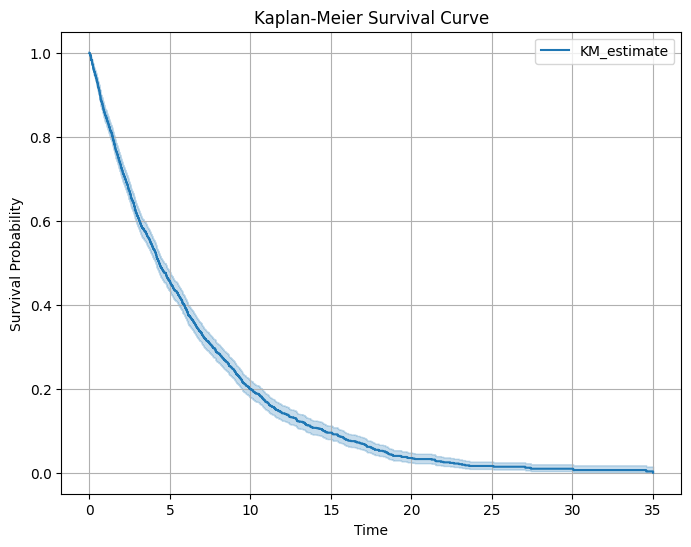

In [6]:
# Kaplan-Meier curve for true survival function
kmf = KaplanMeierFitter()
kmf.fit(df['time_to_event'], event_observed=df['censor'])
true_survival_function = kmf.survival_function_

# Plot the Kaplan-Meier survival function
plt.figure(figsize=(8, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

The curve is fit. Out of the three models I have built, it looks like the XGBoost model is performing the best. This could be for a few different reasons:

*   My parameters may be better fine tuned on the XGBoost model in comparison to the CatBoost model.
*   The amount of variables that are not at a categorical level are better on the model.
*   XGBoost could be handling overfitting, imputation, and other items better.
*   XGBoost appears to be doing regularization on the data a little better.

Let's see how this will look as a prototype on Gradio.

In [7]:
import gradio as gr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Function to update and plot the Kaplan-Meier curve based on user input
def plot_kaplan_meier(censor_rate, time_mean):
    # Generate synthetic data (modify for dynamic adjustments based on user input)
    n = 2000  # Number of samples
    time_to_event = np.random.exponential(time_mean, n)
    censor = np.random.binomial(1, censor_rate, n)

    # Create DataFrame for the synthetic dataset
    df = pd.DataFrame({'time_to_event': time_to_event, 'censor': censor})

    # Kaplan-Meier fitting
    kmf = KaplanMeierFitter()
    kmf.fit(df['time_to_event'], event_observed=df['censor'])

    # Plotting the Kaplan-Meier survival function
    plt.figure(figsize=(8, 6))
    kmf.plot_survival_function()
    plt.title('Simulated Data Kaplan-Meier Survival Curve')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.grid(True)

    # Return the plot to display in the Gradio interface
    return plt.gcf()

# Gradio Interface
iface = gr.Interface(
    fn=plot_kaplan_meier,
    inputs=[
        gr.Slider(minimum=0.5, maximum=1.0, step=0.05, value=0.8, label="Censoring Rate"),
        gr.Slider(minimum=1.0, maximum=10.0, step=0.5, value=5.0, label="Mean Time to Event")
    ],
    outputs=gr.Plot(),
    live=True,
    title="Simulated Data Kaplan-Meier Survival Curve",
    description="Adjust the censoring rate and time to event to visualize the Kaplan-Meier survival curve."
)

# Launch the Gradio app
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ccf01baa99643b74c4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Saving the model to a JSON file
# catboost_model.save_model('catboost_survival_model.json')

In [ ]:
# Downloading
# from google.colab import files
# files.download('catboost_survival_model.json')